In [1]:
import pandas as pd
from processor.processor import Processor as processor
from database.adatabase import ADatabase
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action="ignore")

In [2]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [3]:
prices = []
market = ADatabase("market")
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker})).sort_values("date")
        price["average_return"] = price["adjclose"].pct_change(100)
        for i in range(10):
            price[str(i)] = price["adjclose"].shift(i)
        price["y"] = price["adjclose"].shift(-5)
        prices.append(price.dropna())
    except:
        continue
market.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:47<00:00, 10.66it/s]


In [4]:
prices = pd.concat(prices).sort_values("date")

In [5]:
default_portfolio = {"ticker":"","adjclose":0,"quantity":0,"buy_price":0}
cash = 100
portfolio = default_portfolio.copy()
portfolios = []
for date in tqdm(prices["date"].unique()):
    try:
        # training_dates = [x for x in prices["date"] if x < date][-100:]
        # training_data = prices[prices["date"].isin(training_dates)]
        # sim = prices[prices["date"]==date]
        # model = XGBRegressor(fit_intercept=True)
        # model.fit(training_data[[str(i) for i in range(7)]],training_data["y"])
        # sim["predictions"] = model.predict(sim[[str(i) for i in range(7)]])
        # sim["expected_return"] = (sim["predictions"] - sim["adjclose"]) / sim["adjclose"]
        today = prices[prices["date"]==date]
        rec = today.sort_values("average_return",ascending=True).iloc[0]
        if portfolio["ticker"] == "":
            portfolio["ticker"] = rec["ticker"]
            portfolio["adjclose"] = rec["adjclose"]
            portfolio["quantity"] = cash / rec["adjclose"]
            portfolio["buy_price"] = rec["adjclose"]
            portfolio["date"] = date
            cash = 0
            portfolios.append(portfolio.copy())
        else:
            ## update
            updates = today[today["ticker"]==portfolio["ticker"]].iloc[0]
            portfolio["adjclose"] = updates["adjclose"]
            portfolio["date"] = date
            if rec["ticker"] != portfolio["ticker"]:
                cash = portfolio["adjclose"] * portfolio["quantity"]
                portfolio["ticker"] = rec["ticker"]
                portfolio["adjclose"] = rec["adjclose"]
                portfolio["quantity"] = cash / rec["adjclose"]
                portfolio["buy_price"] = rec["adjclose"]
                portfolio["date"] = date
                cash = 0
                portfolios.append(portfolio.copy())
            else:
                portfolios.append(portfolio.copy())
    except Exception as e:
        print(str(e))
        continue

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4928/4928 [00:39<00:00, 125.19it/s]


In [6]:
states = pd.DataFrame(portfolios)
states["pv"] = states["adjclose"] * states["quantity"]
states["trade"] = states["ticker"] != states["ticker"].shift(-1)

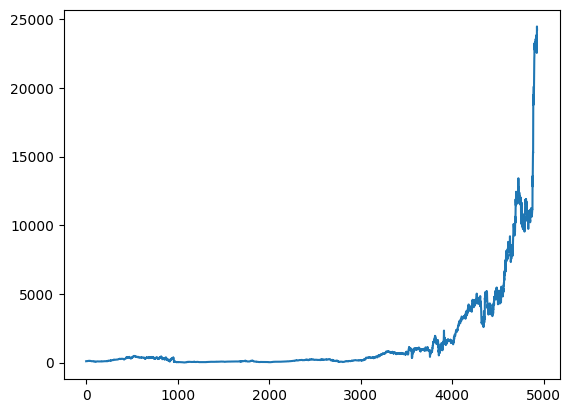

In [7]:
plt.plot(states["pv"])

In [8]:
states[states["trade"]==True]

,ticker,adjclose,quantity,buy_price,date,pv,trade
12,NFLX,1.677141,63.927005,1.564284,2004-12-10 00:00:00+00:00,107.214612,True
15,ALGN,10.470000,10.887344,10.720000,2004-12-15 00:00:00+00:00,113.990493,True
16,WST,9.700680,11.660987,9.700680,2004-12-16 00:00:00+00:00,113.119505,True
17,ALGN,10.320000,11.008035,10.320000,2004-12-17 00:00:00+00:00,113.602922,True
19,WST,9.559730,11.884693,9.568021,2004-12-21 00:00:00+00:00,113.614464,True
...,...,...,...,...,...,...,...
4896,WBD,7.800000,2757.594743,7.800000,2024-05-08 00:00:00+00:00,21509.238992,True
4904,EPAM,191.500000,121.865892,181.930000,2024-05-20 00:00:00+00:00,23337.318316,True
4905,INTC,31.740000,734.343746,31.740000,2024-05-21 00:00:00+00:00,23308.070502,True
4910,LULU,298.540000,77.005241,299.630000,2024-05-29 00:00:00+00:00,22989.144790,True
